In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18, alexnet, mobilenet_v2
import time
import os
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Set random seed for reproducibility and check for CUDA
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Directory to save best model weights
os.makedirs("saved_models", exist_ok=True)

Using device: cuda


In [11]:
def load_and_split_data(transform):
    """Load CIFAR-10 dataset and split into train, validation, and test sets."""
    full_train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Split training data into training and validation (80/20 split)
    train_size = int(0.8 * len(full_train_data))
    val_size = len(full_train_data) - train_size
    train_data, val_data = random_split(full_train_data, [train_size, val_size])

    return train_data, val_data, test_data

def create_dataloaders(train_data, val_data, test_data, batch_size=128):
    """Create data loaders for training, validation, and testing."""
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader

In [12]:
from torchvision.models import resnet18, mobilenet_v2, efficientnet_b0

def initialize_model(model_name):
    """Initialize model based on the specified architecture name."""
    if model_name == "resnet18":
        model = resnet18(weights=None, num_classes=10)
    elif model_name == "mobilenet":
        model = mobilenet_v2(weights=None, num_classes=10)
    elif model_name == "efficientnet":
        model = efficientnet_b0(weights=None, num_classes=10)
    else:
        raise ValueError(f"Model {model_name} is not supported.")
    
    return model.to(device)


In [13]:

def train_epoch(model, train_loader, criterion, optimizer):
    """Train model for one epoch."""
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion):
    """Validate model."""
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [14]:
def plot_experiment_results(results_dict, title):
    """Plot training and validation accuracy/loss for each experiment."""
    plt.figure(figsize=(12, 8))

    # Training Accuracy
    plt.subplot(2, 2, 1)
    for name, results in results_dict.items():
        plt.plot(results['train_accuracies'], label=name)
    plt.title(f"{title} - Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # Validation Accuracy
    plt.subplot(2, 2, 2)
    for name, results in results_dict.items():
        plt.plot(results['val_accuracies'], label=name)
    plt.title(f"{title} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # Training Loss
    plt.subplot(2, 2, 3)
    for name, results in results_dict.items():
        plt.plot(results['train_losses'], label=name)
    plt.title(f"{title} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Validation Loss
    plt.subplot(2, 2, 4)
    for name, results in results_dict.items():
        plt.plot(results['val_losses'], label=name)
    plt.title(f"{title} - Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def save_best_model(model, model_name):
    """Save the best model weights."""
    torch.save(model.state_dict(), f"saved_models/{model_name}_best.pth")

def load_best_model(model_name):
    """Load the best model weights."""
    model = initialize_model(model_name)
    model.load_state_dict(torch.load(f"saved_models/{model_name}_best.pth"))
    return model

In [15]:
# Initial data loading with transformations
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_data, val_data, test_data = load_and_split_data(base_transform)
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data)

Files already downloaded and verified
Files already downloaded and verified


Experiment 1: Architecture Comparison

Training resnet18...
Epoch 1/10: Train Acc: 42.37%, Val Acc: 52.04%
Epoch 2/10: Train Acc: 58.84%, Val Acc: 61.95%
Epoch 3/10: Train Acc: 66.53%, Val Acc: 64.60%
Epoch 4/10: Train Acc: 73.11%, Val Acc: 64.65%
Epoch 5/10: Train Acc: 77.07%, Val Acc: 66.43%
Epoch 6/10: Train Acc: 81.58%, Val Acc: 67.41%
Epoch 7/10: Train Acc: 85.07%, Val Acc: 67.12%
Epoch 8/10: Train Acc: 87.78%, Val Acc: 68.43%
Epoch 9/10: Train Acc: 90.17%, Val Acc: 68.00%
Epoch 10/10: Train Acc: 92.36%, Val Acc: 68.59%

Training mobilenet...
Epoch 1/10: Train Acc: 27.03%, Val Acc: 37.20%
Epoch 2/10: Train Acc: 40.23%, Val Acc: 41.94%
Epoch 3/10: Train Acc: 46.75%, Val Acc: 47.16%
Epoch 4/10: Train Acc: 50.72%, Val Acc: 49.78%
Epoch 5/10: Train Acc: 54.23%, Val Acc: 52.86%
Epoch 6/10: Train Acc: 56.64%, Val Acc: 54.39%
Epoch 7/10: Train Acc: 59.60%, Val Acc: 55.89%
Epoch 8/10: Train Acc: 62.09%, Val Acc: 56.81%
Epoch 9/10: Train Acc: 64.38%, Val Acc: 58.96%
Epoch 10/10: Train Acc:

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000028D57F2EDC0>
Traceback (most recent call last):
  File "c:\Users\dhari\anaconda3\envs\gpu\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\dhari\anaconda3\envs\gpu\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


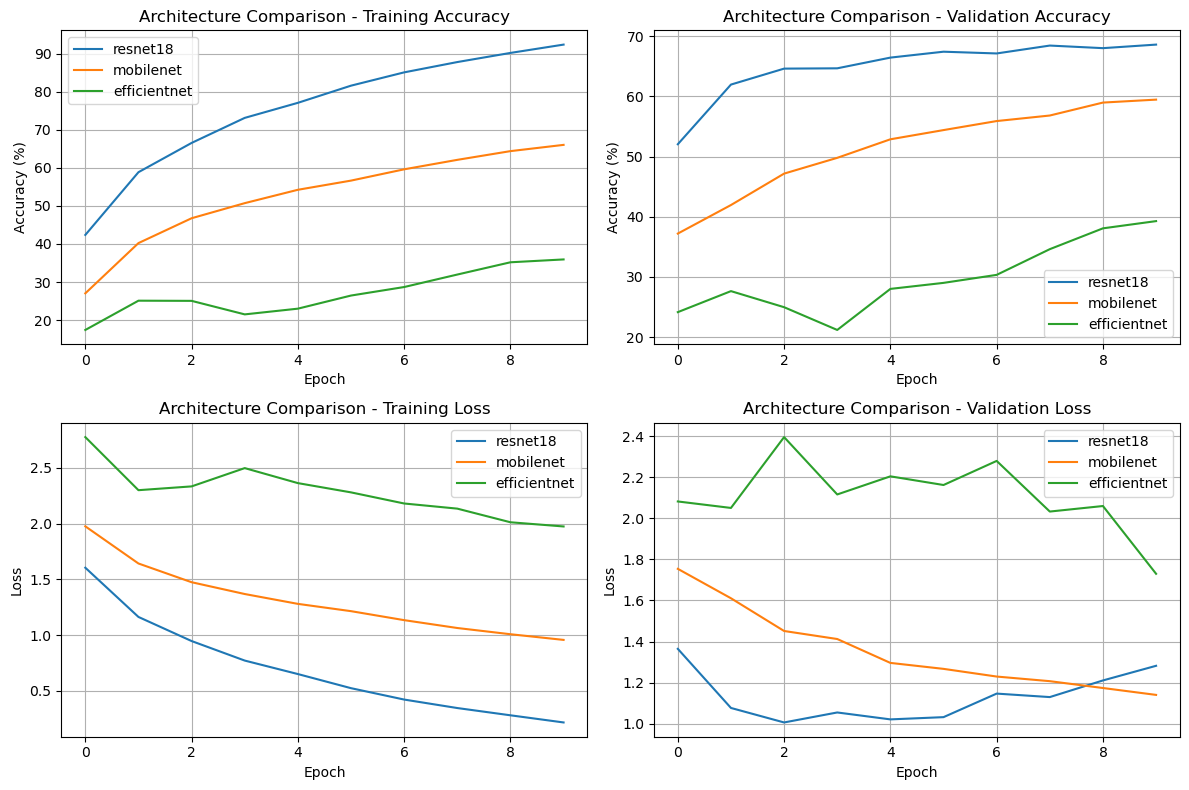

In [16]:
# Experiment 1: Architecture Comparison
print("Experiment 1: Architecture Comparison")
models = ["resnet18", "mobilenet", "efficientnet"]
architecture_results = {}
best_val_accuracy = 0
best_model_name = None

for model_name in models:
    print(f"\nTraining {model_name}...")
    model = initialize_model(model_name)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    start_time = time.time()
    for epoch in range(10):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/10: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    elapsed_time = time.time() - start_time

    architecture_results[model_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'time': elapsed_time
    }

    # Save model if best validation accuracy achieved
    if max(val_accuracies) > best_val_accuracy:
        best_val_accuracy = max(val_accuracies)
        best_model_name = model_name
        save_best_model(model, model_name)

# Plot architecture comparison results
plot_experiment_results(architecture_results, "Architecture Comparison")


Experiment 2: Hyperparameter Tuning

Training with lr=0.01, wd=0
Epoch 1/10: Train Acc: 41.95%, Val Acc: 48.29%
Epoch 2/10: Train Acc: 57.59%, Val Acc: 60.35%
Epoch 3/10: Train Acc: 65.50%, Val Acc: 62.72%
Epoch 4/10: Train Acc: 71.67%, Val Acc: 64.51%
Epoch 5/10: Train Acc: 76.16%, Val Acc: 66.48%
Epoch 6/10: Train Acc: 81.12%, Val Acc: 67.33%
Epoch 7/10: Train Acc: 84.52%, Val Acc: 67.76%
Epoch 8/10: Train Acc: 87.55%, Val Acc: 66.64%
Epoch 9/10: Train Acc: 90.01%, Val Acc: 67.14%
Epoch 10/10: Train Acc: 91.48%, Val Acc: 67.65%

Training with lr=0.01, wd=0.0001
Epoch 1/10: Train Acc: 43.44%, Val Acc: 53.27%
Epoch 2/10: Train Acc: 59.55%, Val Acc: 60.47%
Epoch 3/10: Train Acc: 66.98%, Val Acc: 65.40%
Epoch 4/10: Train Acc: 73.04%, Val Acc: 66.35%
Epoch 5/10: Train Acc: 77.56%, Val Acc: 68.12%
Epoch 6/10: Train Acc: 81.74%, Val Acc: 69.28%
Epoch 7/10: Train Acc: 85.06%, Val Acc: 67.79%
Epoch 8/10: Train Acc: 87.86%, Val Acc: 68.67%
Epoch 9/10: Train Acc: 90.16%, Val Acc: 68.70%
Epoch 

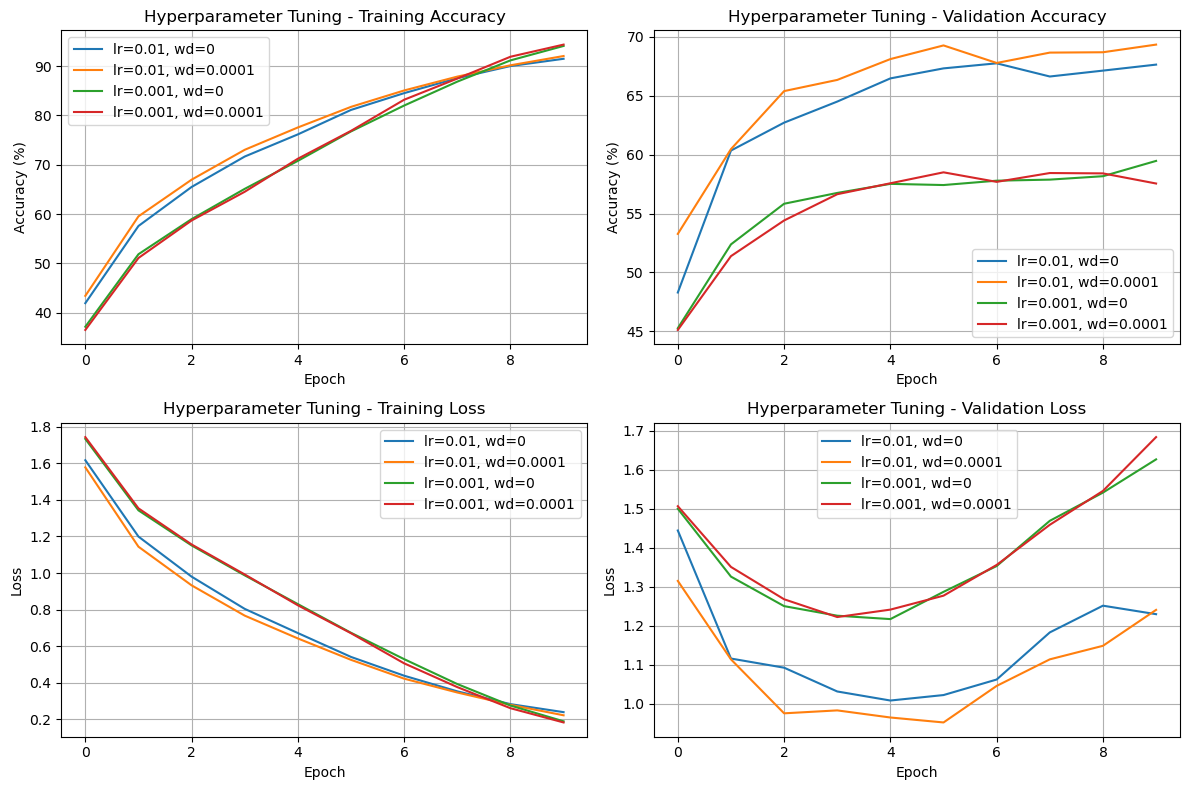

In [17]:
# Experiment 2: Hyperparameter Tuning
print("\nExperiment 2: Hyperparameter Tuning")
learning_rates = [0.01, 0.001]
weight_decays = [0, 1e-4]
hyperparam_results = {}

for lr in learning_rates:
    for wd in weight_decays:
        config_name = f"lr={lr}, wd={wd}"
        print(f"\nTraining with {config_name}")

        model = initialize_model(best_model_name)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        for epoch in range(10):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = validate(model, val_loader, criterion)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch+1}/10: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        hyperparam_results[config_name] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }

# Plot hyperparameter tuning results
plot_experiment_results(hyperparam_results, "Hyperparameter Tuning")



Experiment 3: Data Augmentation

Training with basic augmentation...
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10: Train Acc: 42.26%, Val Acc: 52.31%
Epoch 2/10: Train Acc: 58.17%, Val Acc: 59.07%
Epoch 3/10: Train Acc: 66.34%, Val Acc: 65.31%
Epoch 4/10: Train Acc: 72.26%, Val Acc: 63.60%
Epoch 5/10: Train Acc: 76.95%, Val Acc: 66.54%
Epoch 6/10: Train Acc: 81.09%, Val Acc: 68.68%
Epoch 7/10: Train Acc: 85.16%, Val Acc: 67.86%
Epoch 8/10: Train Acc: 87.42%, Val Acc: 67.92%
Epoch 9/10: Train Acc: 90.35%, Val Acc: 68.92%
Epoch 10/10: Train Acc: 91.97%, Val Acc: 68.00%

Training with moderate augmentation...
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10: Train Acc: 42.53%, Val Acc: 52.87%
Epoch 2/10: Train Acc: 57.72%, Val Acc: 60.87%
Epoch 3/10: Train Acc: 64.94%, Val Acc: 65.95%
Epoch 4/10: Train Acc: 69.68%, Val Acc: 67.49%
Epoch 5/10: Train Acc: 73.29%, Val Acc: 69.05%
Epoch 6/10: Train Acc: 75.91%, V

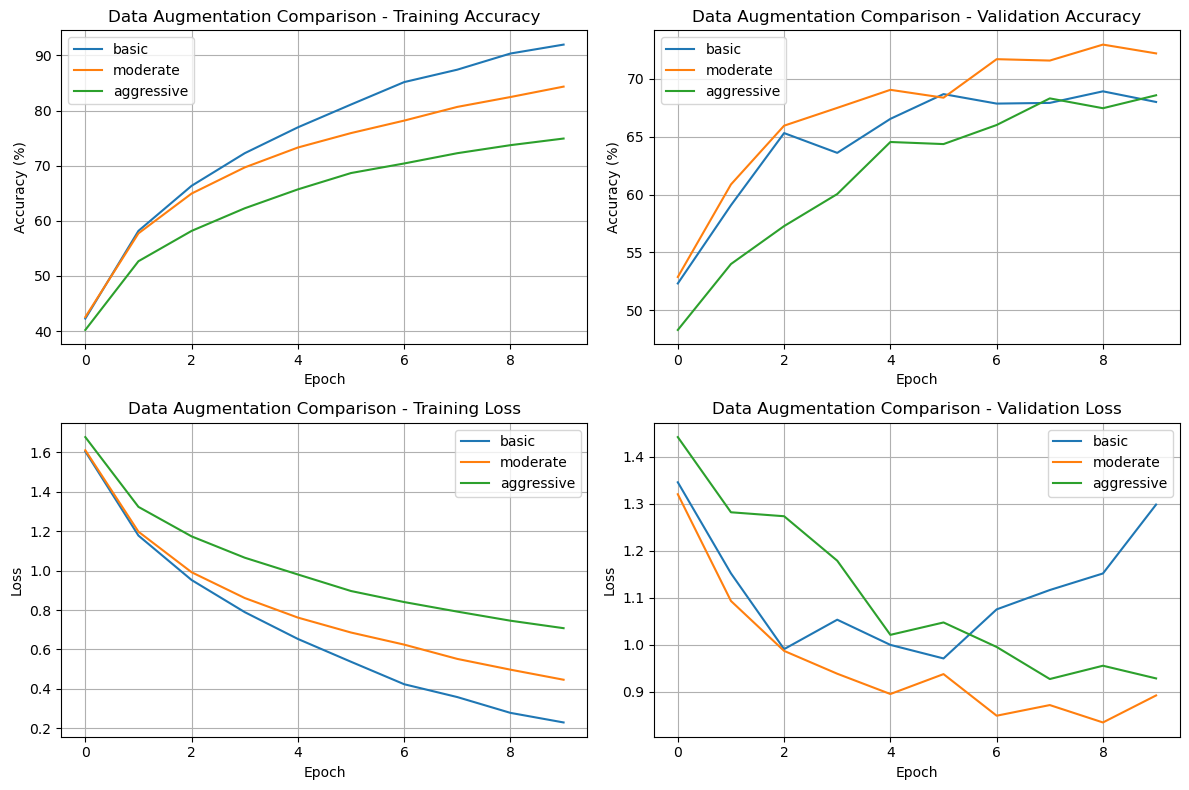

In [19]:
# Experiment 3: Data Augmentation
print("\nExperiment 3: Data Augmentation")
augmentation_transforms = {
    'basic': base_transform,
    'moderate': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
    'aggressive': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
}

augmentation_results = {}
best_aug_accuracy = 0
best_aug_name = None

for aug_name, transform in augmentation_transforms.items():
    print(f"\nTraining with {aug_name} augmentation...")

    # Reload data with new transform
    train_data, val_data, test_data = load_and_split_data(transform)
    train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data)

    model = initialize_model(best_model_name)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(10):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/10: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    augmentation_results[aug_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

    if max(val_accuracies) > best_aug_accuracy:
        best_aug_accuracy = max(val_accuracies)
        best_aug_name = aug_name
        save_best_model(model, best_model_name + f"_{aug_name}")

# Plot augmentation comparison results
plot_experiment_results(augmentation_results, "Data Augmentation Comparison")

In [26]:
# Load best model based on highest validation accuracy from augmentation experiments
final_model_name = best_model_name + f"_{best_aug_name}"
best_model = load_best_model("resnet18")

# Final testing on test dataset
def test_model(model, test_loader, criterion):
    """Evaluate model on test data."""
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    return test_loss, test_acc

# Evaluate the best model on the test set
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = test_model(best_model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Final Test Loss: 1.9555, Test Accuracy: 55.03%


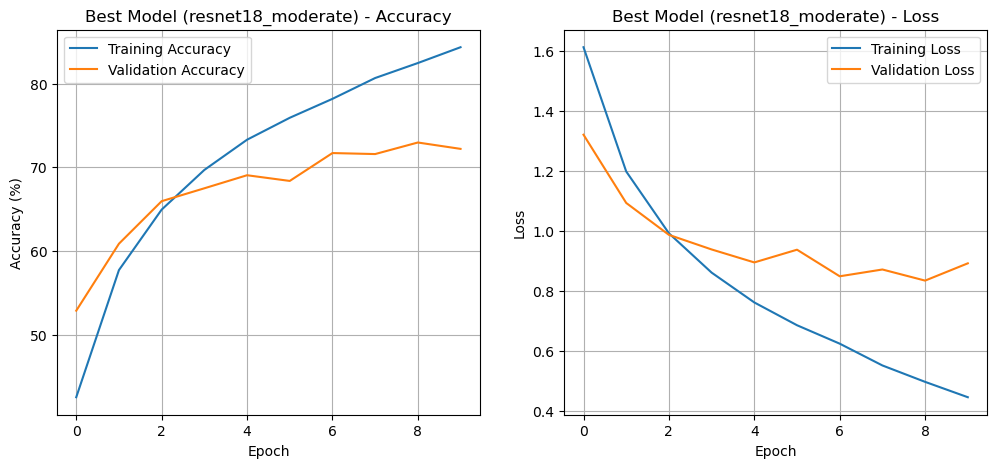

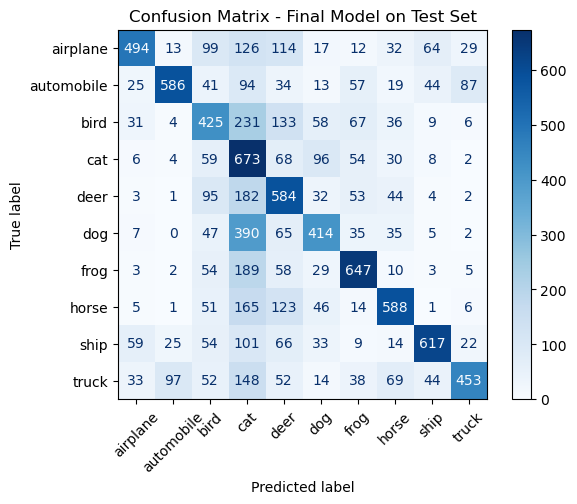

Classification Report - Final Model on Test Set:
              precision    recall  f1-score   support

    airplane       0.75      0.52      0.61      1000
  automobile       0.79      0.56      0.66      1000
        bird       0.45      0.44      0.44      1000
         cat       0.29      0.66      0.40      1000
        deer       0.42      0.57      0.48      1000
         dog       0.54      0.42      0.47      1000
        frog       0.66      0.63      0.64      1000
       horse       0.67      0.58      0.62      1000
        ship       0.80      0.61      0.69      1000
       truck       0.73      0.47      0.57      1000

    accuracy                           0.54     10000
   macro avg       0.61      0.54      0.56     10000
weighted avg       0.61      0.54      0.56     10000



In [27]:
# Additional plots for final model performance
def plot_final_training_curves(results, title_prefix="Final Model"):
    """Plot accuracy and loss for training and validation for the best model."""
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(results['train_accuracies'], label="Training Accuracy")
    plt.plot(results['val_accuracies'], label="Validation Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(results['train_losses'], label="Training Loss")
    plt.plot(results['val_losses'], label="Validation Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.show()

# Plot final training curves for the best model (from augmentation experiment)
plot_final_training_curves(augmentation_results[best_aug_name], title_prefix=f"Best Model ({final_model_name})")

# Confusion Matrix for Final Model on Test Set
def plot_confusion_matrix(model, test_loader):
    """Plot confusion matrix for the best model on the test set."""
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix - Final Model on Test Set")
    plt.show()

# Classification Report for Final Model on Test Set
def classification_report_test(model, test_loader):
    """Print classification report for the best model on the test set."""
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    print("Classification Report - Final Model on Test Set:")
    print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes))

# Plot Confusion Matrix and Classification Report for Final Model
plot_confusion_matrix(best_model, test_loader)
classification_report_test(best_model, test_loader)
